# Is it a banger?

In [1]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd
%matplotlib inline

## The Dataset

In [2]:
df = pd.read_pickle("../data/processed_dataset.pkl")

In [3]:
bangerz = df.loc[df['label'] == "banger"]
clangerz = df.loc[df['label'] == "not_a_banger"]
num_bangerz = bangerz.index.size
num_clangerz = clangerz.index.size
print( "Dataset has %g \"banger\"s and %g \"not_a_banger\"s" % (num_bangerz, num_clangerz) )

Dataset has 422 "banger"s and 453 "not_a_banger"s


In [4]:
def plot_waveforms(df, idx):
    audio = df.iloc[idx].audio
    log_specgram = df.iloc[idx].log_specgram
    filename = df.iloc[idx].name
    label = df.iloc[idx].label
    # audio is np.array holding sample values, log_specgram is 2-dim np.array
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(audio, sr=22050)
    plt.subplot(1, 2, 2)
    librosa.display.specshow(log_specgram, x_axis='time',y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.suptitle(filename + ", label = \"" + label + "\".")


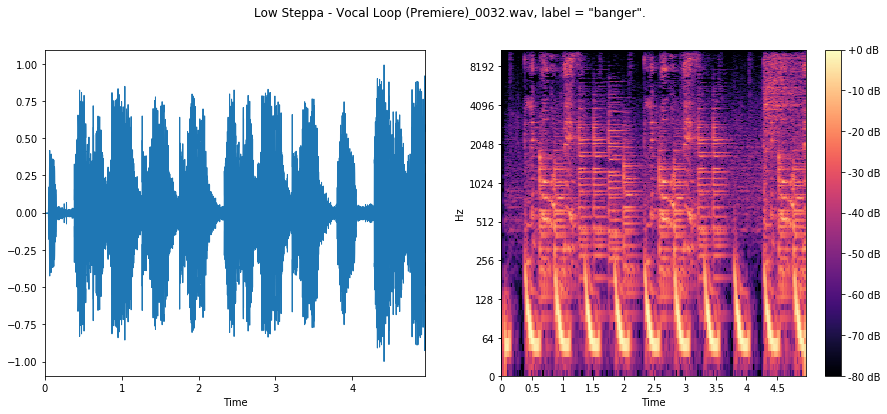

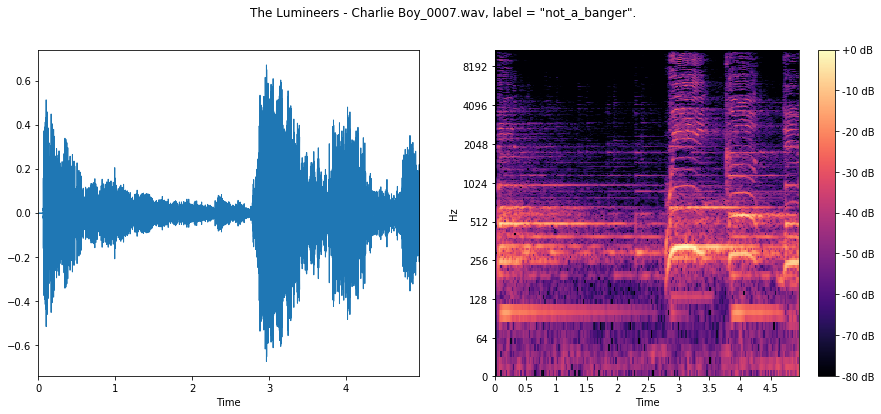

In [5]:
plot_waveforms(bangerz, 1)
plot_waveforms(clangerz, 5)

## Establish baseline

In [6]:
naive_accuracy = (max(num_bangerz, num_clangerz) / (float)(df.index.size))
print ("This is the accuracy if we always guess max{#banger, #not_a_banger}: %.3f" % naive_accuracy)

This is the accuracy if we always guess max{#banger, #not_a_banger}: 0.518


## Form the training and testing data sets¶

In [7]:
train_frac = 0.8

def split_train_test(df, train_frac=0.8):
    include = np.random.rand(*df.index.shape)
    is_train = include < train_frac
    train_data = df[is_train]
    test_data = df[~is_train]
    return train_data, test_data
                
train_data, test_data = split_train_test(df, train_frac)

In [8]:
print(train_data.shape)
print(test_data.shape)

(688, 4)
(187, 4)


In [10]:
import tensorflow as tf
tf.set_random_seed(1234)

In [39]:
# convolution params

log_specgram_shape = df.iloc[0]["log_specgram"].shape
CONV_STRIDE_LENGTH = 1
CONV_WINDOW_LENGTH = 5
MAX_POOL_STRIDE_LENGTH = 2

# features
CONV_1_NUM_FEATURES = 32
CONV_2_NUM_FEATURES = 16
DENSE_NUM_FEATURES = 256

# training
NUM_LABELS = df.label.unique().size
BATCH_SIZE = 50
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
LOG_TRAIN_STEPS = 1

In [40]:
# This node is where we feed a batch of the training data and labels at each training step
x = tf.placeholder(tf.float32,shape=(None, *log_specgram_shape, 1))
y_ = tf.placeholder(tf.float32, shape=(None, len(df.label.unique())))

In [41]:
# Weight initialisation functions
 
# small noise for symmetry breaking and non-zero gradients
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# ReLU neurons - initialise with small positive bias to stop 'dead' neurons
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [42]:
# Convolutions + max pooling

# format: strides = [1, stride, stride, 1]
# W is filter
# input tensor of shape [batch, in_height, in_width, in_channels] 
# and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]
def conv2d(x, W):  
    return tf.nn.conv2d(x, W, strides=[1, CONV_STRIDE_LENGTH, CONV_STRIDE_LENGTH, 1], padding='SAME')

# ksize is filter size
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, MAX_POOL_STRIDE_LENGTH, MAX_POOL_STRIDE_LENGTH, 1],
                        strides=[1, MAX_POOL_STRIDE_LENGTH, MAX_POOL_STRIDE_LENGTH, 1], padding='SAME')



### First Convolutional Layer
We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of `[5, 5, 1, 32]`. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [43]:
W_conv1 = weight_variable([CONV_WINDOW_LENGTH, CONV_WINDOW_LENGTH, 1, CONV_1_NUM_FEATURES])
b_conv1 = bias_variable([CONV_1_NUM_FEATURES])

In [44]:
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [45]:
h_pool1.shape # check shape

TensorShape([Dimension(None), Dimension(513), Dimension(107), Dimension(32)])

### Second Convolutional Layer

In order to build a deep network, we stack several layers of this type. The second layer will have 16 features for each 5x5 patch.

In [46]:
W_conv2 = weight_variable([CONV_WINDOW_LENGTH, CONV_WINDOW_LENGTH, CONV_1_NUM_FEATURES, CONV_2_NUM_FEATURES])
b_conv2 = bias_variable([CONV_2_NUM_FEATURES])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 2x2 maxpool gives image dimensions np.ceil(np.array(log_specgram_shape)/2).astype(int)

In [47]:
h_pool2.shape

TensorShape([Dimension(None), Dimension(257), Dimension(54), Dimension(16)])

### Densely Connected Layer

Now that the image size has been reduced to `$SHAPE`, we add a fully-connected layer with 256 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [48]:
def scale_shape_maxpool2x2(shape_tuple):
    return np.ceil(np.array(shape_tuple)/2).astype(int)

log_specgram_shape_reduced = scale_shape_maxpool2x2(scale_shape_maxpool2x2(log_specgram_shape))

W_fc1 = weight_variable([np.prod(log_specgram_shape_reduced) * CONV_2_NUM_FEATURES, DENSE_NUM_FEATURES])
b_fc1 = bias_variable([DENSE_NUM_FEATURES])

h_pool2_flat = tf.reshape(h_pool2, [-1, np.prod(log_specgram_shape_reduced) * CONV_2_NUM_FEATURES])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [49]:
h_pool2_flat.shape

TensorShape([Dimension(None), Dimension(222048)])

### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a `placeholder` for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's `tf.nn.dropout` op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [50]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout Layer

Finally, we add a layer, just like for the one layer softmax regression.

In [51]:
W_fc2 = weight_variable([DENSE_NUM_FEATURES, NUM_LABELS])
b_fc2 = bias_variable([NUM_LABELS])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

### Batching function

In [52]:
def return_batch(df, batch_size=10):
    batch_df = df.sample(batch_size)
    x = np.vstack(batch_df["log_specgram"]).reshape(batch_df.index.size, *log_specgram_shape, 1).astype(np.float32)
    y = np.vstack(batch_df["label_one_hot"]).astype(np.float32)
    return x, y

### Time logging

In [53]:
import time

def estimate_time_remaining(time_in, current_step, steps_gap, total_steps):
    current_time = time.time() - time_in
    time_per_step = current_time / steps_gap
    time_remaining = (total_steps - current_step) * time_per_step
    m, s = divmod(time_remaining, 60)
    h, m = divmod(m, 60)
    print("Approximately %d hours, %02d minutes, %02d seconds remaining." % (h, m, s))
    

### Train and Evaluate the Model


In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

with sess.as_default():
    current_time = time.time()
    for i in range(NUM_EPOCHS):
        batch = return_batch(train_data, BATCH_SIZE)
        
        # logging
        if i % LOG_TRAIN_STEPS == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %.3f' % (i, train_accuracy))
            estimate_time_remaining(current_time, i, LOG_TRAIN_STEPS, NUM_EPOCHS)
            current_time = time.time()

        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    
    test_batch = return_batch(test_data, test_data.index.size)
    test_accuracy = accuracy.eval(feed_dict={
          x: test_batch[0], y_: test_batch[1], keep_prob: 1.0})
    print('test accuracy %.3f' % test_accuracy)

    saver = tf.train.Saver()
    save_path = saver.save(sess, "model.ckpt")
    print("Model saved in file: %s" % save_path)


step 0, training accuracy 0.440
Approximately 5 hours, 44 minutes, 37 seconds remaining.
step 1, training accuracy 0.540
Approximately 13 hours, 19 minutes, 45 seconds remaining.
step 2, training accuracy 0.500
Approximately 13 hours, 22 minutes, 32 seconds remaining.
step 3, training accuracy 0.560
Approximately 12 hours, 21 minutes, 02 seconds remaining.
step 4, training accuracy 0.580
Approximately 12 hours, 13 minutes, 26 seconds remaining.
step 5, training accuracy 0.560
Approximately 12 hours, 09 minutes, 58 seconds remaining.
step 6, training accuracy 0.500
Approximately 12 hours, 40 minutes, 11 seconds remaining.
step 7, training accuracy 0.500
Approximately 12 hours, 28 minutes, 34 seconds remaining.
step 8, training accuracy 0.540
Approximately 12 hours, 56 minutes, 10 seconds remaining.
step 9, training accuracy 0.600
Approximately 15 hours, 25 minutes, 33 seconds remaining.
step 10, training accuracy 0.780
Approximately 14 hours, 07 minutes, 34 seconds remaining.
step 11, t